# A Dempster-Shafer Theory Model for Penguin Classification

A group of scientists on the Leidos NSF United States Antarctic Program have come to us with a problem. For years, they’ve had a penguin SME take measurements of penguins and provide associated species type. This SME has decided they no longer want to hang out at the South Pole, but instead want a junior employee to, with the help of a model, determine penguin type. Your job as a Leidos AI/ML intern is to build a penguin classifier.

![](joke.png)

### Your job is to take this codebase, which carries out a couple of key pieces of functionality including:
(1) Initializing mass objects for DS analysis <br/>
(2) Calculating the mass for each observation at each variable <br/>
(3) Combining the mass across all variables to determine a hypothesis <br/>
(4) Returning the value with the highest mass as the "most likely" observation <br/>

### And do a couple of things:

(1) See if you can remove problem specific variables from the functions (make code generalizable) <br/>
(2) Include documentation for each functions purpose <br/>
(3) Move all functions to a separate module and call them in to this notebook<br/>
(4) Come up with a better way to handle cases where the outcome is indeterminate by DS mass combination; ideally it should get more of those indeterminates correct. <br/>
(5) For a given mass set, show you can implement the get_belief and get_plausibility function. The code for get_belief and get_plausibility already exists within the set, but I would like to see you call those functions for a given mass set as part of the "get_output" function described below. <br/>
(6) See if you can make the code for DS into a class that implements over a dataset object <br/>
(7) What other improvements can be made? How could this model be made better? (while remaining within the DST Construct)


## Setup and Data Analysis

(You do not need to edit this section)

In [3]:
# Be sure to install my pre-created environment for you to work in so that we can all agree on python versions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Penguins come in three flavors: Chinstrap, Gentoo, and Adelie, and we have measurements for penguin beak, flippers, body mass, and sex. Our dataset is small-ish – only 344 entries, our compute power is limited, and we have no more money to go out and collect more penguin data. So we sat down and had a group meeting about how we might build this model. One approach might be to cluster the data (perhaps k-means), one could also try a Bayesian belief network, another option could be a net-based “classifier”, maybe a regression style technique could be employed, or a tree-based method. There are many different model options (and in the real world, you might actually try several of these techniques), but your team has decided that they don’t just want a prediction and associated probability, but also a way for us to understand the strength of the evidence in favor of our prediction and the level of uncertainty based on the evidence in the system. So, we turn to Dempster Shafer theory (DST). 

DST is a general framework for reasoning with uncertainty, developed as a way to combine evidence from different source and arrive at a degree of belief that takes into account all the available evidence. For more info on DST for a classification – here’s a fun use description  http://bennycheung.github.io/dempster-shafer-theory-for-classification

Our problem is rather similar to benny cheung’s github posting. Except, we’ve decided to use the included codebase. 

Your boss tells you that this model needs to be demo-ed to the Anatarica team on Monday,  December 7th. 

In [4]:
#My penguin data
penguins = pd.read_csv("penguins.csv")
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


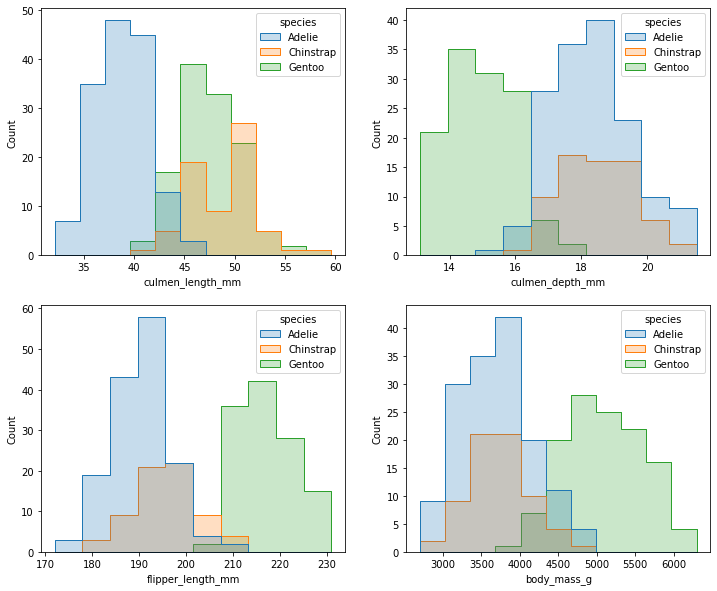

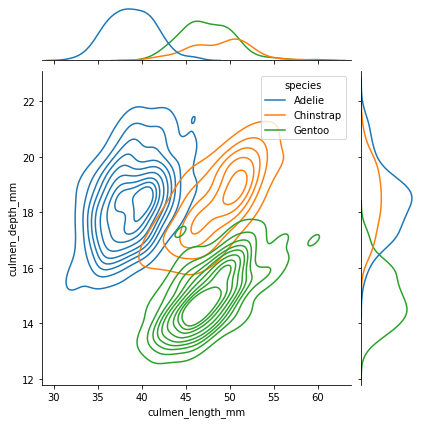

In [5]:
# Let's Get a sense of what the data looks like:
fd, axes = plt.subplots(2, 2, figsize=(12, 10))

for fd, ax in [('culmen_length_mm',axes[0,0]), ('culmen_depth_mm',axes[0,1]), ('flipper_length_mm',axes[1,0]), ('body_mass_g',axes[1,1])]:
    sns.histplot(penguins, x=fd, hue='species', element='step', ax=ax)
    
sns.jointplot(
    data=penguins,
    x="culmen_length_mm", y="culmen_depth_mm", hue="species",
    kind="kde"
)

## Model Construction

Based on initial data analysis and a quick discussion, you team decided that you were only going to ue features 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'. A senior resarcher then puts together a first cut at the code. Then, your graduate teammate cleaned up the combined mass function, get belief, and get plausibility code, but left everything else untouched.

In [6]:
#Initialize hypothesis - all either badly written functions, or perhaps there's an issue...
# THIS IS THE CODE THAT MOST DESPARATELY REQUIRES YOUR EDITING

def classRangeOutput():
    classRange = {}
    for c in penguins.species.unique():
        fieldRange = {}
        for f in ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']:
            fieldRange[f] =(penguins[penguins.species == c][f].min(), penguins[penguins.species == c][f].max())
        classRange[c] = fieldRange
    return classRange

def powerset(s):
    output = []
    x = len(s)
    for i in range(1 << x):
        val = [s[j] for j in range(x) if (i & (1 << j))]
        initial = [val, 0.0]
        output.append(initial)
    return output


def hypothesis(df, classRange, fieldName, value):
    hset = []
    for c in df.species.unique():
        if (classRange[c][fieldName][0] <= value and value < classRange[c][fieldName][1]):
            hset.append(c)
    return hset

def hypothesisCounts(hypothesisCount, h):
    if len(h) == 1 or len(h) == 2:
        for i in range(0, len(hypothesisCount)):
            if(hypothesisCount[i][0] == h):
                hypothesisCount[i][1] += 0.9
                hypothesisCount[-1][1] += 0.1
    else:
        hypothesisCount[-1][1] += 1


In [7]:
# THIS CODE DOES NOT REQUIRE EDITING, BUT SHOULD BE PUT INTO YOUR dempsterShafer.py module
# Your graduate teammate wrote this code. It shouldn't need any changes.
# Dempster Shafer combination, belief, and plausibility calculations.
def combine_masses(d1, d2):
    """
    Purpose: Combine loaded, validated masses in accordance with the rules of dempster-shafer
    
    keyword arguments:
    d1 -- detection from first sensor considered of the format
    [[['a'], 0.5],[['b'], 0.3], [['a','b'], 0.2]]
    d2 -- detection from second sensor considered of the format
    [[['a'], 0.5],[['b'], 0.3], [['a','b'], 0.2]]
    
    return:
    if valid mass file, return loaded detections in the following format
    [[['a'], 0.5], [['b'], 0.3], [['a','b'], 0.2]]
    
    if not valid mass file, return error
    """
    
    combined_masses = []
    
    # Combine by multiplication and generate all subgroup components, including the
    # Null-space created by this fusion
    for hypothesis_d1 in d1:
        for hypothesis_d2 in d2:
            joint_list = list(set(hypothesis_d1[0]).intersection(hypothesis_d2[0]))
            if len(joint_list) == 0:
                joint_list = ['null']
                    
            if joint_list in [x[0] for x in combined_masses]:
                for i in combined_masses:
                    if i[0] == joint_list:
                        i[1] += round(hypothesis_d1[1] * hypothesis_d2[1],4)


            else:
                combined_masses.append([joint_list, round(hypothesis_d1[1] * hypothesis_d2[1],4)])

    ##Scale by null accordingly if it exists/has been created during fusion
    if ['null'] in [i[0] for i in combined_masses]:
        K = 1 - round([i[1] for i in combined_masses if i[0] == ['null']][0],4)
    else: 
        K = 1
    combined_masses = [[i[0],round(i[1]/K,6)] for i in combined_masses if i[0] != ['null']]
    
    if round(check_sums(combined_masses),2) == 1:
        
        return combined_masses

    else:
        return """an error has occurred, mass fusion has not returned a result of 1. 
                For dempster-shafer to run, it must hold that masses sum to 1. Your
                mass fusion has returned: """+ str(round(check_sums(combined_masses),4))


def check_sums(detections):
    """
    Purpose: Confirm that the masses within the text file sum to 1. 
    
    keyword arguments: 
    detections -- loaded detection nested list of the following format
    [[['a'], 0.5],[['b'], 0.3], [['a','b'], 0.2]]
    
    return:
    validate -- return whether or not this detection list is valad (aka the masses sum to 1)
    """
    
    return sum([i[1] for i in detections])

    
def get_belief(mass):
    """
    Purpose: For a given set of masses, get the belief - 
    the lower bound of probability, such that it is the sum of all
    masses where B is a subset of A
    
    keyword arguements:
    
    mass -- the mass for the weights you would like to get DS 
    style belief for
    
    return: the belief for DS
    """
    beliefs = []
    
    for i in range(0, len(mass)):
        subset_calc = [k[1] for k in mass if set(k[0]).issubset(set(mass[i][0]))]
        belief = round(sum(subset_calc),4)
        beliefs.append([mass[i][0], belief])
        
    return beliefs

def get_plausibility(mass):
    """
    Purpose: For a given set of masses, get the belief - 
    the lower bound of probability, such that it is the sum of all
    masses where B is a subset of A
    
    keyword arguements:
    
    mass -- the mass for the weights you would like to get DS 
    style plausibility for
    
    return: the belief for DS
    """
    plausibilities = []
    
    for i in range(0, len(mass)):
        subset_calc = [k[1] for k in mass if set(k[0]).intersection(set(mass[i][0]))]
        plausibility = round(sum(subset_calc),4)
        plausibilities.append([mass[i][0], plausibility])
        
    return plausibilities

## Run Model and Analyze Results

This code needs to be cleaned up too

In [8]:
## Now we predict - this could really be cleaned up too

classRange = classRangeOutput()
fields =  ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
correct = 0
incorrect = 0
indeterminate = 0
for index, row in penguins.iterrows():
    sample = row
    masses = {}
    for f in fields:
        hypothesisCount = powerset(penguins.species.unique())
        h = hypothesis(penguins, classRange, f, row[f])
        hypothesisCounts(hypothesisCount, h)
        total = sum([i[1] for i in hypothesisCount])
        for i in range(0, len(hypothesisCount)):
            hypothesisCount[i][1] = hypothesisCount[i][1]/total
            masses[f] = hypothesisCount
    masses_comb1 = combine_masses(masses['culmen_length_mm'], masses['culmen_depth_mm'])
    masses_comb2 = combine_masses(masses_comb1, masses['flipper_length_mm'])
    masses_comb3 = combine_masses(masses_comb2, masses['body_mass_g'])
    
    
    ## Find the highest output of combined Mass
    vals = 0
    for i in range(0, len(masses_comb3)):
        if masses_comb3[i][1] > vals:
            most_likely = masses_comb3[i][0]
            vals = masses_comb3[i][1]
    if len(most_likely) == 1:
        if most_likely[0] == row["species"]:
            correct += 1
        else:
            incorrect += 1
            
    ## For situations where multiple classes are selected as the most likely
    ## We declare them wrong. 
    
    ## What could we do here to provide a second way of differentiating between the two classes? 
    ## Try something.
    if len(most_likely) != 1:
        indeterminate += 1
        
    ## For each observation; we should also be able to get a sense of our belief and the plausibility. 

            
print("We had ", correct, "correct classifications") 
print("We had ", incorrect, "incorrect classifications")
print("We had ", indeterminate, "indeterminate classifications")


def get_output(mass):
    belief = ds.get_belief(mass)
    plausibility = ds.get_plausibility(mass)
    together = [[mass[i][0], mass[i][1], belief[i][1], plausibility[i][1]] for i in range(0, len(mass))]
    return pd.DataFrame(together, columns = ['hypothesis', 'mass', 'belief', 'plausibility'])

                    

We had  290 correct classifications
We had  6 incorrect classifications
We had  48 indeterminate classifications
